In [5]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import seaborn as sns

In [6]:
import warnings
warnings.simplefilter("ignore")

# Load files

In [7]:
DATA_PATH = "BazaCut/"
FILIP_PATH = DATA_PATH + "wordsFilip/"
SEB_PATH = DATA_PATH + "wordsSebastian/"
MARCIN_PATH = DATA_PATH + "wordsMarcin/"
PROFESSOR_PATH = DATA_PATH + "wordsProfessor/"
no_of_words = 30
prefixes = ["F","S","M","P"]
Fs = 48000
words_filip = no_of_words*[0]
words_seb = no_of_words*[0]
words_marcin = no_of_words*[0]
words_professor = no_of_words*[0]


for i in range(1, no_of_words+1):
    file_name = "word"+str(i)+"_F"+".wav"
    y, sr = librosa.load(FILIP_PATH+file_name, sr=None)
    words_filip[i-1] = y

    file_name = "word"+str(i)+"_S"+".wav"
    y, sr = librosa.load(SEB_PATH+file_name, sr=None)
    words_seb[i-1] = y

    file_name = "word"+str(i)+"_M"+".wav"
    y, sr = librosa.load(MARCIN_PATH+file_name, sr=None)
    words_marcin[i-1] = y

    file_name = "word"+str(i)+"_L"+".wav"
    y, sr = librosa.load(PROFESSOR_PATH+file_name, sr=None)
    words_professor[i-1] = y


# Visualization of chromagrams

Text(0.5, 1.0, 'Chroma VQT')

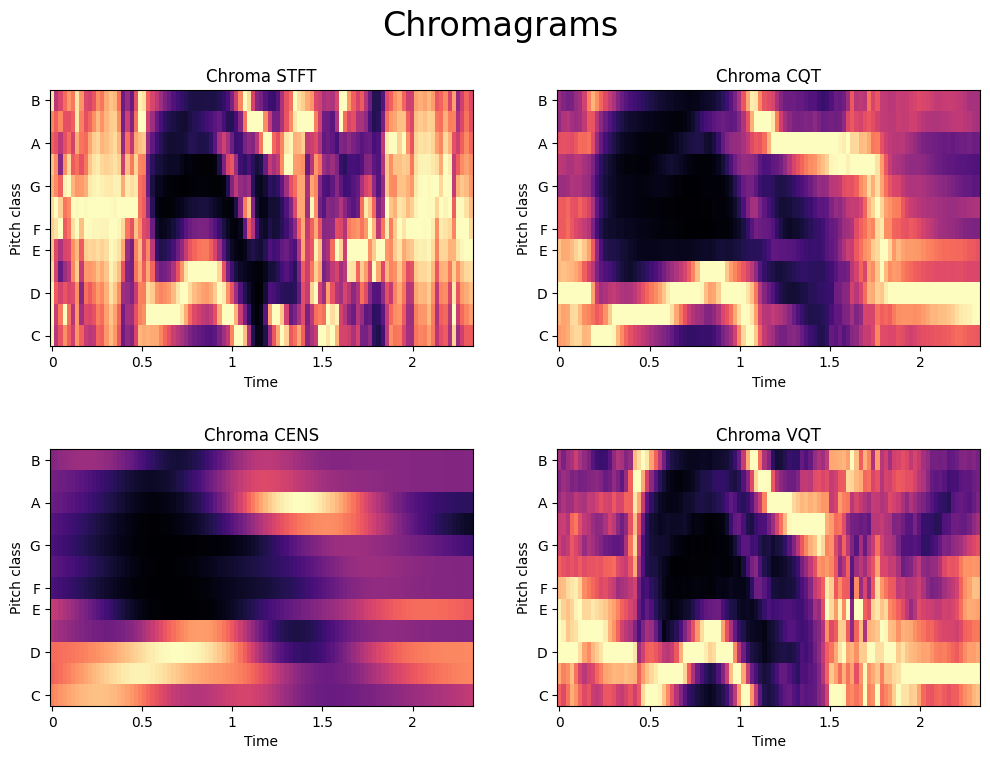

In [8]:
chroma_stft = librosa.feature.chroma_stft(y=words_marcin[0], sr=sr)
chroma_cqt = librosa.feature.chroma_cqt(y=words_marcin[0], sr=sr)
chroma_cens = librosa.feature.chroma_cens(y=words_marcin[0], sr=sr)
chroma_vqt = librosa.feature.chroma_vqt(y=words_marcin[0], sr=sr, intervals="equal")

import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

plt.suptitle("Chromagrams", fontsize=24)
plt.subplots_adjust(hspace=0.4)

img = librosa.display.specshow(chroma_stft, y_axis='chroma', x_axis='time', ax=ax[0, 0])
ax[0,0].set_title("Chroma STFT")

img = librosa.display.specshow(chroma_cqt, y_axis='chroma', x_axis='time', ax=ax[0, 1])
ax[0,1].set_title("Chroma CQT")

img = librosa.display.specshow(chroma_cens, y_axis='chroma', x_axis='time', ax=ax[1, 0])
ax[1,0].set_title("Chroma CENS")

librosa.display.specshow(chroma_vqt, y_axis='chroma', x_axis='time', ax=ax[1, 1])
ax[1,1].set_title("Chroma VQT")



# 

# Voices classification

## Podejście 1.
Po obliczeniu cech chromatycznych obliczana jest średnia dla każdego z półtonów. W ten sposób dla każdego dźwięku powstaje wektor cech składający się z 12 wartości zmiennoprzecinkowych

In [44]:
all_words = [words_filip, words_marcin, words_seb, words_professor]
labels_og = ["F", "M", "S", "P"]
chroma_types ={
    "stft": {
        "func": librosa.feature.chroma_stft,
        "params": {},
    },
    "cqt": {
        "func": librosa.feature.chroma_cqt,
        "params": {},
    },
    "cens": {
        "func": librosa.feature.chroma_cens,
        "params": {},
    },
    "vqt": {
        "func": librosa.feature.chroma_vqt,
        "params": {"intervals": "equal"},
    }
}

accuracies = []

for chroma_name in chroma_types:
    print(f"*** {chroma_name.upper()} ***")
    feature_vector = []
    y = []
    for words, label in zip(all_words, labels_og):
        for audio in words:
            word_stft = chroma_types[chroma_name]["func"](y=audio, sr=sr, **chroma_types[chroma_name]["params"])
            feature_vector.append(word_stft.mean(axis=1).flatten())
            y.append(label)

    feature_vector = np.array(feature_vector)
    labels = np.array(y)

    X_train, X_test, y_train, y_test = train_test_split(feature_vector, labels, test_size=0.5, random_state=0)
    
    # Normalize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    classifiers = [
        ("SVM", SVC(random_state=0)),
        ("Random Forest", RandomForestClassifier(random_state=0)),
        ("MLP", MLPClassifier(random_state=0))
    ]
    for clf in classifiers:
        clf[1].fit(X_train, y_train)
        y_pred = clf[1].predict(X_test)

        print(clf[0])
        accuracies.append(
            {
                "chroma_name": chroma_name,
                "algo": clf[0],
                "accuracy": accuracy_score(y_test, y_pred),
                "classification_report": classification_report(y_test, y_pred),
                "report_dict": classification_report(y_test, y_pred, output_dict=True),
                "confusion_matrix": confusion_matrix(y_test, y_pred),
            }
        )
        print("Accuracy:", accuracy_score(y_test, y_pred))
        # print(classification_report(y_test, y_pred))
        print()


*** STFT ***
SVM
Accuracy: 0.4166666666666667

Random Forest
Accuracy: 0.5

MLP
Accuracy: 0.4666666666666667

*** CQT ***
SVM
Accuracy: 0.7666666666666667

Random Forest
Accuracy: 0.7166666666666667

MLP
Accuracy: 0.75

*** CENS ***
SVM
Accuracy: 0.8

Random Forest
Accuracy: 0.7

MLP
Accuracy: 0.7833333333333333

*** VQT ***
SVM
Accuracy: 0.7166666666666667

Random Forest
Accuracy: 0.6666666666666666

MLP
Accuracy: 0.7333333333333333



In [14]:
classification_report(y_test, y_pred, output_dict=True)

{'F': {'precision': 0.7368421052631579,
  'recall': 0.7777777777777778,
  'f1-score': 0.7567567567567568,
  'support': 18.0},
 'M': {'precision': 0.8571428571428571,
  'recall': 1.0,
  'f1-score': 0.9230769230769231,
  'support': 12.0},
 'P': {'precision': 0.7058823529411765,
  'recall': 0.75,
  'f1-score': 0.7272727272727273,
  'support': 16.0},
 'S': {'precision': 0.6,
  'recall': 0.42857142857142855,
  'f1-score': 0.5,
  'support': 14.0},
 'accuracy': 0.7333333333333333,
 'macro avg': {'precision': 0.7249668288367979,
  'recall': 0.7390873015873015,
  'f1-score': 0.7267766017766017,
  'support': 60.0},
 'weighted avg': {'precision': 0.7207164971251658,
  'recall': 0.7333333333333333,
  'f1-score': 0.7222484722484722,
  'support': 60.0}}

In [17]:

print(reports)

{'STFT': {'MLP': {'F': {'precision': 0.5714285714285714, 'recall': 0.6666666666666666, 'f1-score': 0.6153846153846154, 'support': 18.0}, 'M': {'precision': 0.2727272727272727, 'recall': 0.25, 'f1-score': 0.2608695652173913, 'support': 12.0}, 'P': {'precision': 0.21428571428571427, 'recall': 0.1875, 'f1-score': 0.2, 'support': 16.0}, 'S': {'precision': 0.7142857142857143, 'recall': 0.7142857142857143, 'f1-score': 0.7142857142857143, 'support': 14.0}, 'accuracy': 0.4666666666666667, 'macro avg': {'precision': 0.4431818181818181, 'recall': 0.45461309523809523, 'f1-score': 0.4476349737219303, 'support': 60.0}, 'weighted avg': {'precision': 0.44978354978354973, 'recall': 0.4666666666666667, 'f1-score': 0.45678929765886284, 'support': 60.0}}}, 'CQT': {'MLP': {'F': {'precision': 0.7, 'recall': 0.7777777777777778, 'f1-score': 0.7368421052631579, 'support': 18.0}, 'M': {'precision': 0.9166666666666666, 'recall': 0.9166666666666666, 'f1-score': 0.9166666666666666, 'support': 12.0}, 'P': {'precis

In [43]:
import numpy as np
import matplotlib.pyplot as plt

def plot_comparison(accuracies):
    reports = {}
    for acc in accuracies:
        reports[acc["chroma_name"].upper()] = {}
        reports[acc["chroma_name"].upper()][acc["algo"].upper()] = acc["report_dict"]

    # Extract metrics: precision, recall, f1-score, accuracy
    methods = list(reports.keys())
    metrics = ['precision', 'recall', 'f1-score', 'accuracy']

    # Calculate averages
    averages = {}

    for method, algorithms in reports.items():
        averages[method] = []
        for algo, report in algorithms.items():
            # Average precision, recall, f1-score across classes (ignoring 'macro avg', 'weighted avg', etc.)
            precision = np.mean([v['precision'] for k, v in report.items() if k not in ['accuracy', 'macro avg', 'weighted avg']])
            recall = np.mean([v['recall'] for k, v in report.items() if k not in ['accuracy', 'macro avg', 'weighted avg']])
            f1 = np.mean([v['f1-score'] for k, v in report.items() if k not in ['accuracy', 'macro avg', 'weighted avg']])
            accuracy = report['accuracy']
            averages[method].append([precision, recall, f1, accuracy])

    # Compute the average of metrics across all algorithms for each feature extraction method
    final_averages = {method: np.mean(values, axis=0) for method, values in averages.items()}

    # Plot grouped bar chart
    x = np.arange(len(methods))  # Positions for feature extraction methods
    width = 0.2  # Width of the bars

    fig, ax = plt.subplots(figsize=(8, 4))

    for i, metric in enumerate(metrics):
        metric_values = [final_averages[method][i] for method in methods]
        ax.bar(x + i * width, metric_values, width, label=metric)

    # Labeling
    ax.set_xlabel('Feature Extraction Methods')
    ax.set_ylabel('Scores')
    ax.set_title('Metrics by Feature Extraction Method')
    ax.set_xticks(x + width * 1.5)  # Center the groups
    ax.set_xticklabels(methods)
    ax.legend()

    plt.tight_layout()
    plt.show()


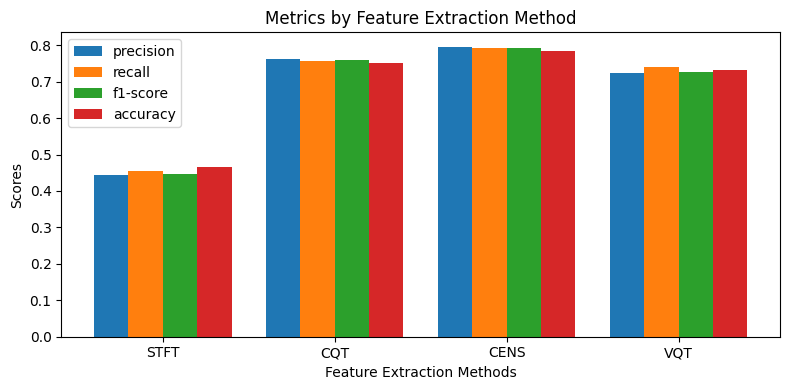

In [24]:
plot_comparison(accuracies)

In [7]:
accuracies.sort(key=lambda x: x["accuracy"], reverse=True)

for acc in accuracies:
    print(f"Chroma: {acc['chroma_name']}.\tAlgorithm: {acc['algo']}\tAccuracy: {acc['accuracy']}.")

Chroma: cens.	Algorithm: SVM	Accuracy: 0.8.
Chroma: cens.	Algorithm: MLP	Accuracy: 0.7833333333333333.
Chroma: cqt.	Algorithm: SVM	Accuracy: 0.7666666666666667.
Chroma: cqt.	Algorithm: MLP	Accuracy: 0.75.
Chroma: vqt.	Algorithm: MLP	Accuracy: 0.7333333333333333.
Chroma: cqt.	Algorithm: Random Forest	Accuracy: 0.7166666666666667.
Chroma: vqt.	Algorithm: SVM	Accuracy: 0.7166666666666667.
Chroma: cens.	Algorithm: Random Forest	Accuracy: 0.7.
Chroma: vqt.	Algorithm: Random Forest	Accuracy: 0.6666666666666666.
Chroma: stft.	Algorithm: Random Forest	Accuracy: 0.5.
Chroma: stft.	Algorithm: MLP	Accuracy: 0.4666666666666667.
Chroma: stft.	Algorithm: SVM	Accuracy: 0.4166666666666667.


- Algorytm `Random Forest` wypada zdecydowanie najgorzej spośród porównywanych. `SVM` i `MLP` zachowują się porównywalnie
- Cechy chromatyczne dające najlepszą skuteczność klasyfikacji uzyskano przy pomocy metody `cens`. Metoda `stft` daje sdecydowanie najgorsze wyniki.

### Best 3 results

Chroma: cens
              precision    recall  f1-score   support

           F       0.86      0.67      0.75        18
           M       1.00      0.92      0.96        12
           P       0.65      0.94      0.77        16
           S       0.83      0.71      0.77        14

    accuracy                           0.80        60
   macro avg       0.84      0.81      0.81        60
weighted avg       0.83      0.80      0.80        60



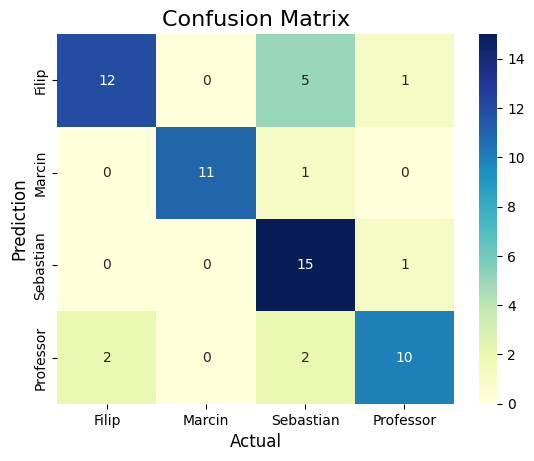


Chroma: cens
              precision    recall  f1-score   support

           F       0.81      0.72      0.76        18
           M       0.92      0.92      0.92        12
           P       0.68      0.81      0.74        16
           S       0.77      0.71      0.74        14

    accuracy                           0.78        60
   macro avg       0.80      0.79      0.79        60
weighted avg       0.79      0.78      0.78        60



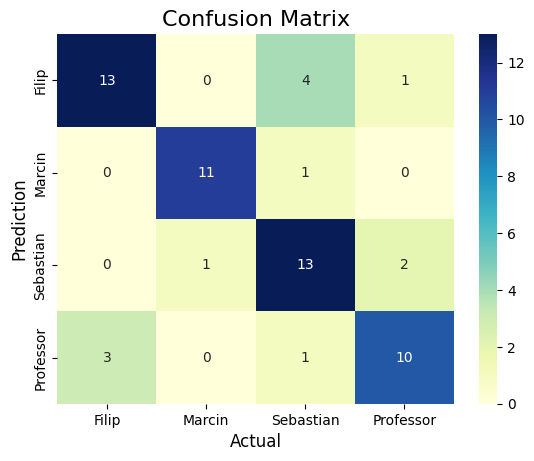


Chroma: cqt
              precision    recall  f1-score   support

           F       0.76      0.72      0.74        18
           M       1.00      0.92      0.96        12
           P       0.67      0.88      0.76        16
           S       0.73      0.57      0.64        14

    accuracy                           0.77        60
   macro avg       0.79      0.77      0.77        60
weighted avg       0.78      0.77      0.77        60



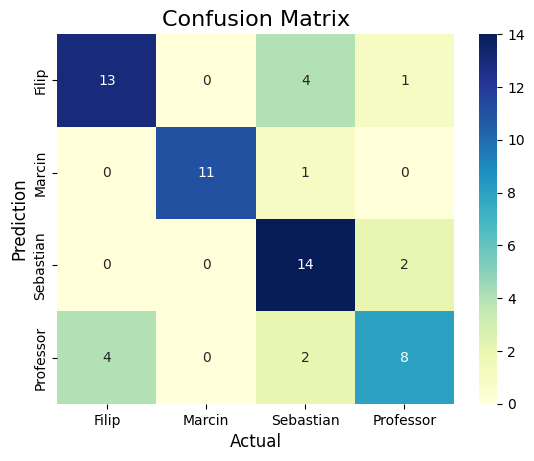

In [8]:
for acc in accuracies[:3]:
    print(f"Chroma: {acc['chroma_name']}")
    print(acc["classification_report"])
    ticks = ["Filip","Marcin","Sebastian", "Professor"]
    
    # Plot the confusion matrix
    sns.heatmap(acc["confusion_matrix"], annot=True,fmt='d', cmap='YlGnBu',xticklabels=ticks, yticklabels=ticks )
    plt.ylabel('Prediction',fontsize=12)
    plt.xlabel('Actual',fontsize=12)
    plt.title('Confusion Matrix',fontsize=16)
    plt.show()
    print()

## Podejście 2
Zamiast obliczać średnią, interpoluje każdy z obliczonych wektorów cech chromatycznych do jednakowej długości.

In [27]:
def interpolate_to_length(array_2d, target_length):
    rows, original_length = array_2d.shape
    interpolated_array = np.zeros((rows, target_length))
    original_indices = np.linspace(0, original_length - 1, num=original_length)
    target_indices = np.linspace(0, original_length - 1, num=target_length)
    
    for i in range(rows):
        interpolated_array[i, :] = np.interp(target_indices, original_indices, array_2d[i, :])
    
    return interpolated_array

In [36]:
feature_vector = []
y = []
for words, label in zip(all_words, labels_og):
    for audio in words:
        word_stft = librosa.feature.chroma_cens(y=audio, sr=sr)
        feature_vector.append(interpolate_to_length(word_stft, 10).flatten())
        y.append(label)

feature_vector = np.array(feature_vector)
labels = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(feature_vector, labels, test_size=0.5, random_state=0)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

classifiers = [
    ("SVM", SVC(random_state=0)),
    ("Random Forest", RandomForestClassifier(random_state=0)),
    ("MLP", MLPClassifier(random_state=0))
]
accuracies = []
for clf in classifiers:
    clf[1].fit(X_train, y_train)
    y_pred = clf[1].predict(X_test)

    print(clf[0])
    accuracies.append(
        {
            "chroma_name": chroma_name,
            "algo": clf,
            "accuracy": accuracy_score(y_test, y_pred),
            "report_dict": classification_report(y_test, y_pred, output_dict=True),
        }
    )
    print("Accuracy:", accuracy_score(y_test, y_pred))

    # Detailed classification report
    print(classification_report(y_test, y_pred))
    print()

SVM
Accuracy: 0.9
              precision    recall  f1-score   support

           F       1.00      0.83      0.91        18
           M       1.00      1.00      1.00        12
           P       0.78      0.88      0.82        16
           S       0.87      0.93      0.90        14

    accuracy                           0.90        60
   macro avg       0.91      0.91      0.91        60
weighted avg       0.91      0.90      0.90        60


Random Forest
Accuracy: 0.8833333333333333
              precision    recall  f1-score   support

           F       0.94      0.83      0.88        18
           M       1.00      1.00      1.00        12
           P       0.81      0.81      0.81        16
           S       0.81      0.93      0.87        14

    accuracy                           0.88        60
   macro avg       0.89      0.89      0.89        60
weighted avg       0.89      0.88      0.88        60


MLP
Accuracy: 0.8666666666666667
              precision    recall 

Jak widać to podejście jest zdecydowanie lepsze. Pozwala uzyskać dokładność do 90%. Warto więc sprawdzić czy zinterpolowanie oryginalnych cech do dłuższych liczb nie dałoby lepszych rezultatów.

In [41]:
def plot_comparison_by_interp(accuracies):
    # Group data by interp
    reports = {}
    for acc in accuracies:
        interp = acc["interp"]
        if interp not in reports:
            reports[interp] = {}
        reports[interp][f'{acc["chroma_name"].upper()}_{acc["algo"].upper()}'] = acc["report_dict"]

    # Extract metrics: precision, recall, f1-score, accuracy
    interp_lengths = sorted(reports.keys())  # Ensure interp values are in sorted order
    metrics = ['precision', 'recall', 'f1-score', 'accuracy']

    # Calculate averages
    averages = {}

    for interp, results in reports.items():
        averages[interp] = []
        for _, report in results.items():
            # Average precision, recall, f1-score across classes (ignoring 'macro avg', 'weighted avg', etc.)
            precision = np.mean([v['precision'] for k, v in report.items() if k not in ['accuracy', 'macro avg', 'weighted avg']])
            recall = np.mean([v['recall'] for k, v in report.items() if k not in ['accuracy', 'macro avg', 'weighted avg']])
            f1 = np.mean([v['f1-score'] for k, v in report.items() if k not in ['accuracy', 'macro avg', 'weighted avg']])
            accuracy = report['accuracy']
            averages[interp].append([precision, recall, f1, accuracy])

    # Compute the average of metrics across all feature extraction methods and algorithms for each interp length
    final_averages = {interp: np.mean(values, axis=0) for interp, values in averages.items()}

    # Plot grouped bar chart
    x = np.arange(len(interp_lengths))  # Positions for interp lengths
    width = 0.2  # Width of the bars

    fig, ax = plt.subplots(figsize=(8, 4))

    for i, metric in enumerate(metrics):
        metric_values = [final_averages[interp][i] for interp in interp_lengths]
        ax.bar(x + i * width, metric_values, width, label=metric)

    # Labeling
    ax.set_xlabel('Interpolation Length')
    ax.set_ylabel('Scores')
    ax.set_title('Metrics by Interpolation Length')
    ax.set_xticks(x + width * 1.5)  # Center the groups
    ax.set_xticklabels(interp_lengths)
    ax.legend()

    plt.tight_layout()
    plt.show()


In [37]:
interp_lengths = [5, 10, 20, 30, 50]
accuracies = []

for interp_len in interp_lengths:

    feature_vector = []
    y = []
    for words, label in zip(all_words, labels_og):
        for audio in words:
            word_stft = librosa.feature.chroma_cens(y=audio, sr=sr)
            feature_vector.append(interpolate_to_length(word_stft, interp_len).flatten())
            y.append(label)

    feature_vector = np.array(feature_vector)
    labels = np.array(y)

    X_train, X_test, y_train, y_test = train_test_split(feature_vector, labels, test_size=0.5, random_state=0)

    # Normalize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    classifiers = [
        ("SVM", SVC(random_state=0)),
        ("Random Forest", RandomForestClassifier(random_state=0)),
        ("MLP", MLPClassifier(random_state=0))
    ]
    for clf in classifiers:
        clf[1].fit(X_train, y_train)
        y_pred = clf[1].predict(X_test)

        print(clf[0])
        accuracies.append(
            {
                "chroma_name": chroma_name,
                "algo": clf[0],
                "accuracy": accuracy_score(y_test, y_pred),
                "classification_report": classification_report(y_test, y_pred),
                "confusion_matrix": confusion_matrix(y_test, y_pred),
                "report_dict": classification_report(y_test, y_pred, output_dict=True),
                "interp": interp_len,
            }
        )
        print("Accuracy:", accuracy_score(y_test, y_pred))
        print()

SVM
Accuracy: 0.8666666666666667

Random Forest
Accuracy: 0.9166666666666666

MLP
Accuracy: 0.8666666666666667

SVM
Accuracy: 0.9

Random Forest
Accuracy: 0.8833333333333333

MLP
Accuracy: 0.8666666666666667

SVM
Accuracy: 0.8833333333333333

Random Forest
Accuracy: 0.9

MLP
Accuracy: 0.8666666666666667

SVM
Accuracy: 0.8833333333333333

Random Forest
Accuracy: 0.8833333333333333

MLP
Accuracy: 0.8833333333333333

SVM
Accuracy: 0.8833333333333333

Random Forest
Accuracy: 0.8666666666666667

MLP
Accuracy: 0.85



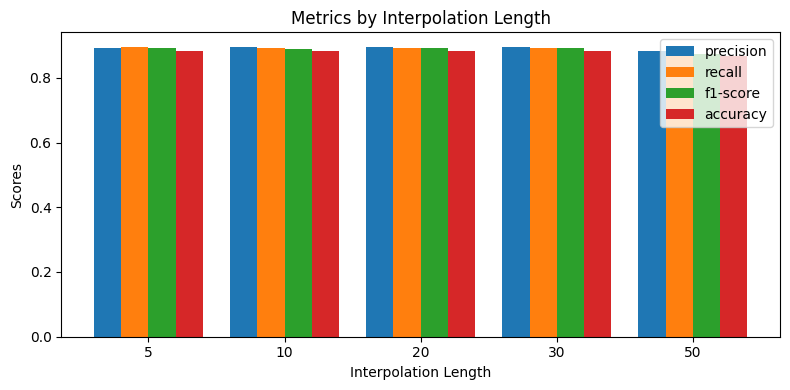

In [42]:
plot_comparison_by_interp(accuracies)

In [12]:
accuracies.sort(key=lambda x: x["accuracy"], reverse=True)

for acc in accuracies:
    print(f"Chroma: CENS.\t Interpolated vector length: {acc['interp']}\tAlgorithm: {acc['algo']}\tAccuracy: {acc['accuracy']}.")

Chroma: CENS.	 Interpolated vector length: 5	Algorithm: Random Forest	Accuracy: 0.9166666666666666.
Chroma: CENS.	 Interpolated vector length: 10	Algorithm: SVM	Accuracy: 0.9.
Chroma: CENS.	 Interpolated vector length: 20	Algorithm: Random Forest	Accuracy: 0.9.
Chroma: CENS.	 Interpolated vector length: 10	Algorithm: Random Forest	Accuracy: 0.8833333333333333.
Chroma: CENS.	 Interpolated vector length: 20	Algorithm: SVM	Accuracy: 0.8833333333333333.
Chroma: CENS.	 Interpolated vector length: 30	Algorithm: SVM	Accuracy: 0.8833333333333333.
Chroma: CENS.	 Interpolated vector length: 30	Algorithm: Random Forest	Accuracy: 0.8833333333333333.
Chroma: CENS.	 Interpolated vector length: 30	Algorithm: MLP	Accuracy: 0.8833333333333333.
Chroma: CENS.	 Interpolated vector length: 50	Algorithm: SVM	Accuracy: 0.8833333333333333.
Chroma: CENS.	 Interpolated vector length: 5	Algorithm: SVM	Accuracy: 0.8666666666666667.
Chroma: CENS.	 Interpolated vector length: 5	Algorithm: MLP	Accuracy: 0.8666666666

- Uzyskane skuteczności są zdecydowanie lepsze niż przy podejściu pierwszym.
- Algorytm `Random Forest` zrównał się z `SVC` i wyprzedził `MLP` pod względem skuteczności
- Nie widać wyraźnego wzorca między długością interpolowanego wektora. Zdecydowanie jest to jednak lepsza meteoda niż obliczanie średniej.

Chroma: CENS
              precision    recall  f1-score   support

           F       0.94      0.89      0.91        18
           M       1.00      1.00      1.00        12
           P       0.88      0.88      0.88        16
           S       0.87      0.93      0.90        14

    accuracy                           0.92        60
   macro avg       0.92      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60



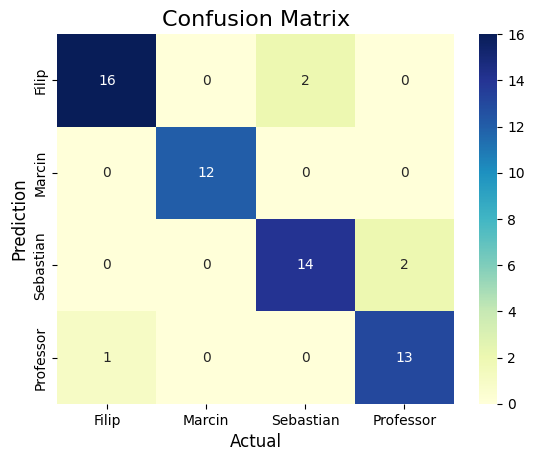


Chroma: CENS
              precision    recall  f1-score   support

           F       1.00      0.83      0.91        18
           M       1.00      1.00      1.00        12
           P       0.78      0.88      0.82        16
           S       0.87      0.93      0.90        14

    accuracy                           0.90        60
   macro avg       0.91      0.91      0.91        60
weighted avg       0.91      0.90      0.90        60



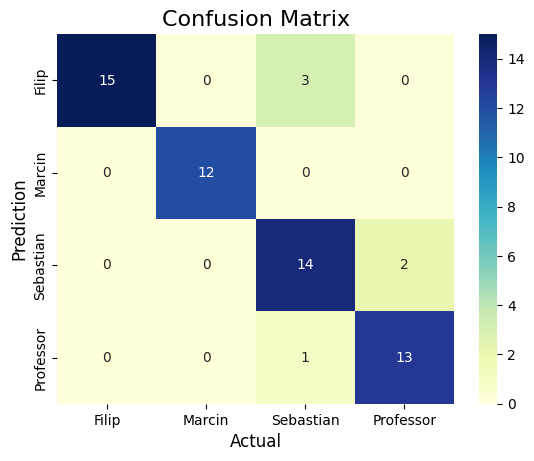


Chroma: CENS
              precision    recall  f1-score   support

           F       0.94      0.89      0.91        18
           M       1.00      1.00      1.00        12
           P       0.87      0.81      0.84        16
           S       0.81      0.93      0.87        14

    accuracy                           0.90        60
   macro avg       0.91      0.91      0.90        60
weighted avg       0.90      0.90      0.90        60



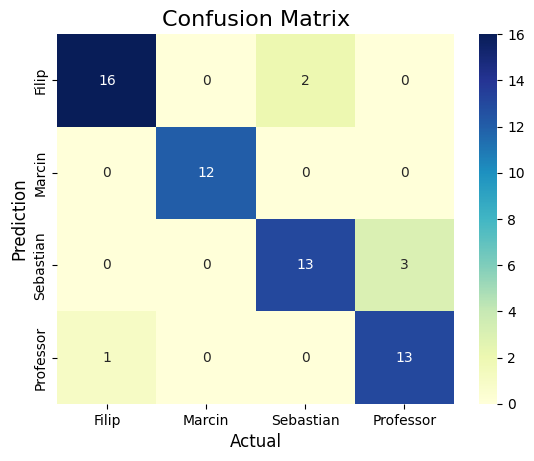

In [13]:
for acc in accuracies[:3]:
    print(f"Chroma: CENS")
    print(acc["classification_report"])
    ticks = ["Filip","Marcin","Sebastian", "Professor"]
    
    # Plot the confusion matrix
    sns.heatmap(acc["confusion_matrix"], annot=True,fmt='d', cmap='YlGnBu',xticklabels=ticks, yticklabels=ticks )
    plt.ylabel('Prediction',fontsize=12)
    plt.xlabel('Actual',fontsize=12)
    plt.title('Confusion Matrix',fontsize=16)
    plt.show()
    print()